# Logistic regression on MNIST data

Example use of nabla to learn logistic regression classifiers on the MNIST digit dataset.

## Load and visualise data

Found data nsamples=60000, nrow=28, ncol=28
Found 60000 labels
Found data nsamples=10000, nrow=28, ncol=28
Found 10000 labels


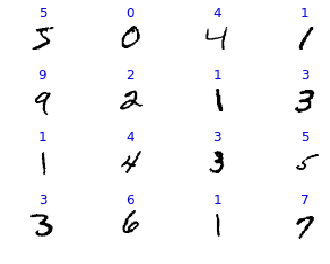

In [274]:
import matplotlib.pyplot as plt
import mnist_data
%matplotlib inline
%load_ext autoreload
%autoreload 2

train_images, train_labels, test_images, test_labels, nrow, ncol = mnist_data.get_train_test_data()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i,:].reshape((nrow,ncol)), cmap="Greys")
    plt.title(train_labels[i], color="b")
    plt.axis("off")
plt.subplots_adjust(hspace=1)
plt.show()

## Learn one-vs-rest classifiers using logistic regression

In [267]:
import numpy as np
from nabla import grad

def p(X, theta):
    return 1/(1 + np.exp(-np.dot(theta,X)))

def negloglik(theta, X, Y):
    N = X.shape[0]
    ret = 0
    for i in range(N):
        px = p(X[i,:], theta)
        ret += Y[i]*np.log(px) + (1-Y[i])*np.log(1-px)
    return -ret/N

def shuffle(X, Y):
    assert X.shape[0]==len(Y)
    perm = np.random.permutation(len(Y))
    return X[perm,:], Y[perm]

def train(Xtrain, Ytrain, theta0, alpha=1e-5, batchsize=32, epochs=5):
    # Nesterov accelerated momentum
    gamma = 0.9
    vt = 0
    N = Xtrain.shape[0]
    assert N%batchsize==0
    Nbatches = N//batchsize
    for ep in range(epochs):
        print("epoch {}".format(ep))
        X, Y = shuffle(Xtrain, Ytrain)
        for batch in range(Nbatches):
            func = grad(lambda theta : negloglik(theta, X[batch*batchsize:(batch+1)*batchsize,:], Y[batch*batchsize:(batch+1)*batchsize]))
            f = func(theta0 - gamma*vt)
            vt = gamma*vt + alpha*f.dual
            theta0 = theta0 - vt
            if batch%1000==0 or batch==Nbatches-1:
                print("batch {}/{}: fval = {}, normgradsq = {}".format(batch, Nbatches, f.real, np.dot(f.dual,f.dual)))
    return theta0

N = train_images.shape[0]
Xtrain = train_images[0:N, :]
# Bias term
Xtrain = np.concatenate((Xtrain, np.ones((Xtrain.shape[0],1))), axis=1)
# Train binary classifiers
classifiers = dict()
for i in range(10):
    print("Training classifier {}".format(i))
    Ytrain = (train_labels[0:N]==i).astype(float)
    theta0 = np.zeros(Xtrain.shape[1])
    theta = train(Xtrain, Ytrain, theta0, alpha=1e-6, batchsize=32, epochs=5)
    classifiers[i] = theta

Training classifier 0
epoch 0
batch 0/1875: fval = 0.6931471805599448, normgradsq = 234494.2177734375
batch 1000/1875: fval = 0.0206239183899648, normgradsq = 956.8772410680659
batch 1874/1875: fval = 0.007502060030471052, normgradsq = 64.5141883662385
epoch 1
batch 0/1875: fval = 0.004489117536520032, normgradsq = 44.65045818433048
batch 1000/1875: fval = 0.007603431706232828, normgradsq = 88.28109741323337
batch 1874/1875: fval = 0.005559501845088486, normgradsq = 29.591571772581162
epoch 2
batch 0/1875: fval = 0.006296588394877989, normgradsq = 90.14770348911259
batch 1000/1875: fval = 0.0039313208126650415, normgradsq = 13.1957733810788
batch 1874/1875: fval = 0.007009622677957945, normgradsq = 110.85622351396673
epoch 3
batch 0/1875: fval = 0.035846757346253935, normgradsq = 1312.3177274819977
batch 1000/1875: fval = 0.009582056359319276, normgradsq = 187.57894376852744
batch 1874/1875: fval = 0.004001345158720923, normgradsq = 66.06073177360585
epoch 4
batch 0/1875: fval = 0.0019

batch 1000/1875: fval = 0.013056982426456079, normgradsq = 890.6864335516583
batch 1874/1875: fval = 0.09914802757734187, normgradsq = 4755.816522919969
Training classifier 7
epoch 0
batch 0/1875: fval = 0.6931471805599448, normgradsq = 345683.2795410156
batch 1000/1875: fval = 0.03242105487681801, normgradsq = 836.3400472621963
batch 1874/1875: fval = 0.04064951185538719, normgradsq = 3321.522086178011
epoch 1
batch 0/1875: fval = 0.016301431117264984, normgradsq = 179.01088674389877
batch 1000/1875: fval = 0.010324738184109717, normgradsq = 233.23970728390177
batch 1874/1875: fval = 0.07591244099830952, normgradsq = 3876.826299395592
epoch 2
batch 0/1875: fval = 0.03951304960446577, normgradsq = 771.6092210430575
batch 1000/1875: fval = 0.04507298345270226, normgradsq = 1413.620043476051
batch 1874/1875: fval = 0.04509302347744375, normgradsq = 4883.481697463505
epoch 3
batch 0/1875: fval = 0.007542110799033598, normgradsq = 62.35653216727371
batch 1000/1875: fval = 0.086529369996318

## Visualise classifier weights:

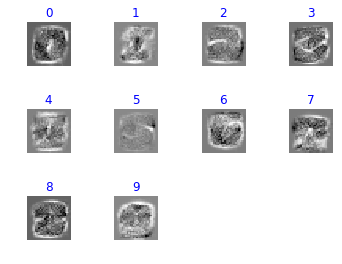

In [268]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(classifiers[i][:-1].reshape((nrow,ncol)), cmap="Greys")
    plt.title(str(i), color="b")
    plt.axis("off")
plt.subplots_adjust(hspace=1)
plt.show()

## Get train and test accuracy

In [269]:
def classify_single(X, classifiers):
    probs = np.zeros(10)
    for i in range(10):
        probs[i] = p(X, classifiers[i])
    return np.argmax(probs)

def predict(X, classifiers):
    N = X.shape[0]
    Ypred = np.zeros(N)
    for i in range(N):
        Ypred[i] = classify_single(X[i,:], classifiers)
    return Ypred

def accuracy(Y, Ypred):
    return sum(Y==Ypred)/len(Y)


Ypredtrain = predict(Xtrain, classifiers)
Ytrain = train_labels[0:N]
train_acc = accuracy(Ytrain, Ypredtrain)

Xtest = test_images
# Bias term
Xtest = np.concatenate((Xtest, np.ones((Xtest.shape[0],1))), axis=1)
Ytest = test_labels
Ypredtest = predict(Xtest, classifiers)
test_acc = accuracy(Ytest, Ypredtest)

print("train accuracy = {}".format(train_acc))
print("test accuracy = {}".format(test_acc))

train accuracy = 0.91605
test accuracy = 0.9154


## Plot some random test data with our predictions

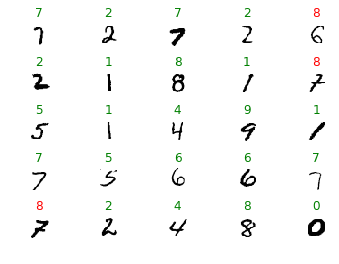

In [271]:
perm = np.random.permutation(test_images.shape[0])
for i in range(25):
    j = perm[i]
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[j,:].reshape((nrow,ncol)), cmap="Greys")
    if Ypredtest[j]==Ytest[j]:
        col = "g"
    else:
        col = "r"
    plt.title(int(Ypredtest[j]), color=col)
    plt.axis("off")
plt.subplots_adjust(hspace=1)
plt.show()